In [1]:
import matplotlib.pyplot as plt
import numpy as np
from model import CulturalModel
import pandas as pd
import seaborn as sns

Running simulation for min_connectivity = 0.25
  - Snapping grid state at step 0
  - Snapping grid state at step 250
  - Snapping grid state at step 750
  - Snapping grid state at step 1000
Running simulation for min_connectivity = 0.5
  - Snapping grid state at step 0
  - Snapping grid state at step 250
  - Snapping grid state at step 750
  - Snapping grid state at step 1000
Running simulation for min_connectivity = 0.75
  - Snapping grid state at step 0
  - Snapping grid state at step 250
  - Snapping grid state at step 750
  - Snapping grid state at step 1000
Running simulation for min_connectivity = 1.0
  - Snapping grid state at step 0
  - Snapping grid state at step 250
  - Snapping grid state at step 750
  - Snapping grid state at step 1000


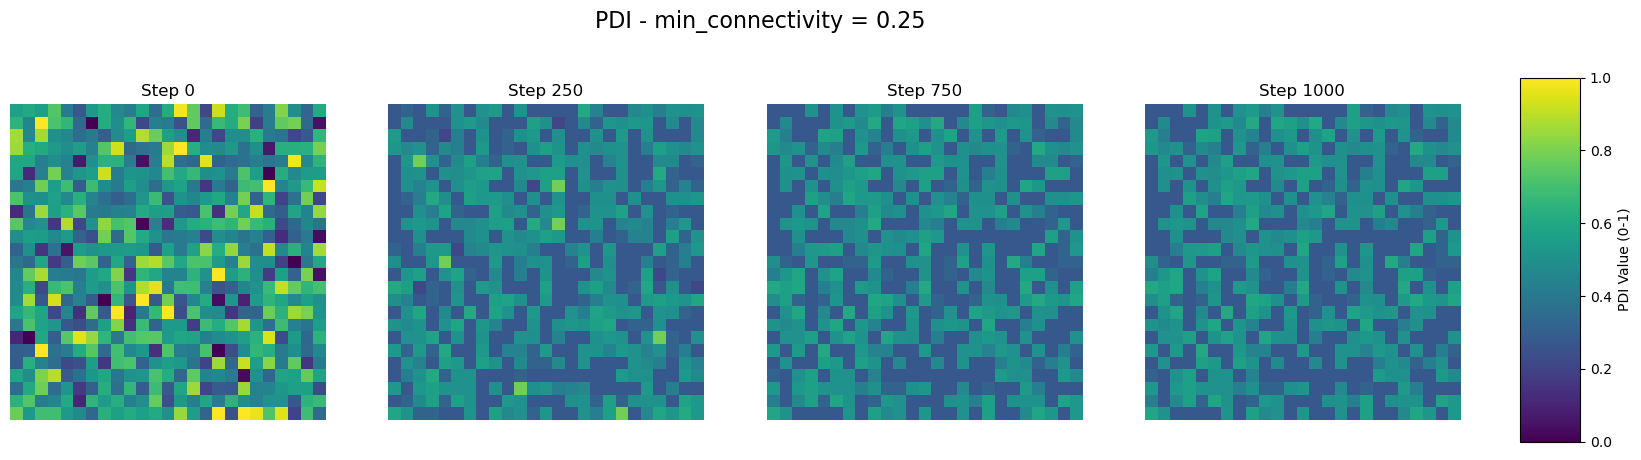

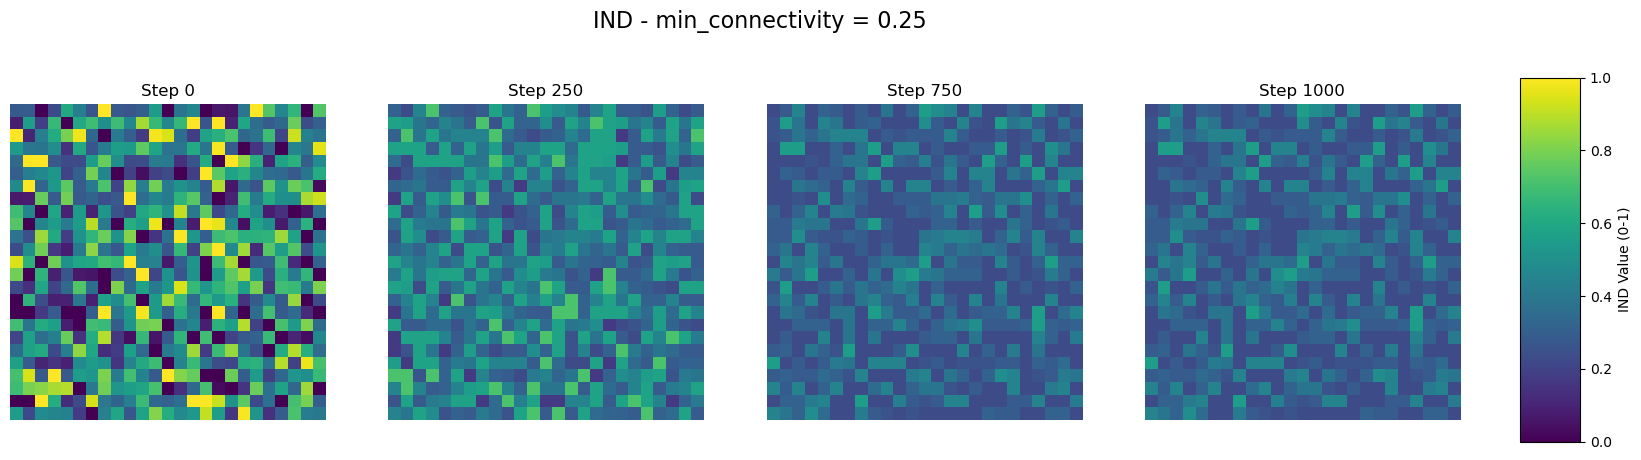

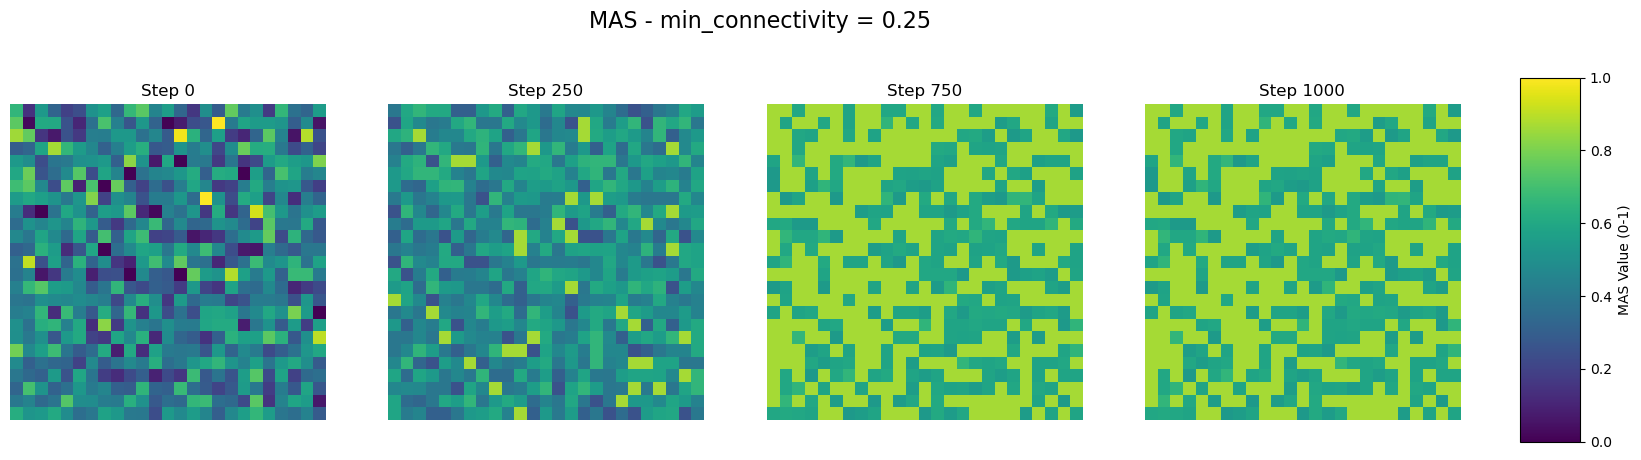

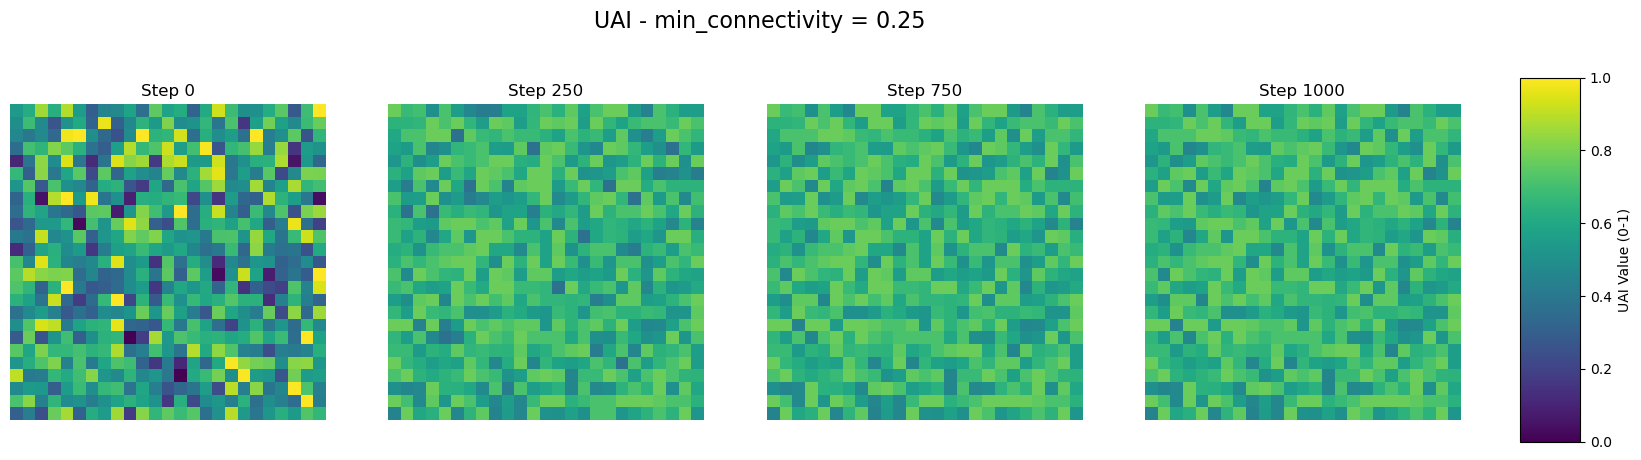

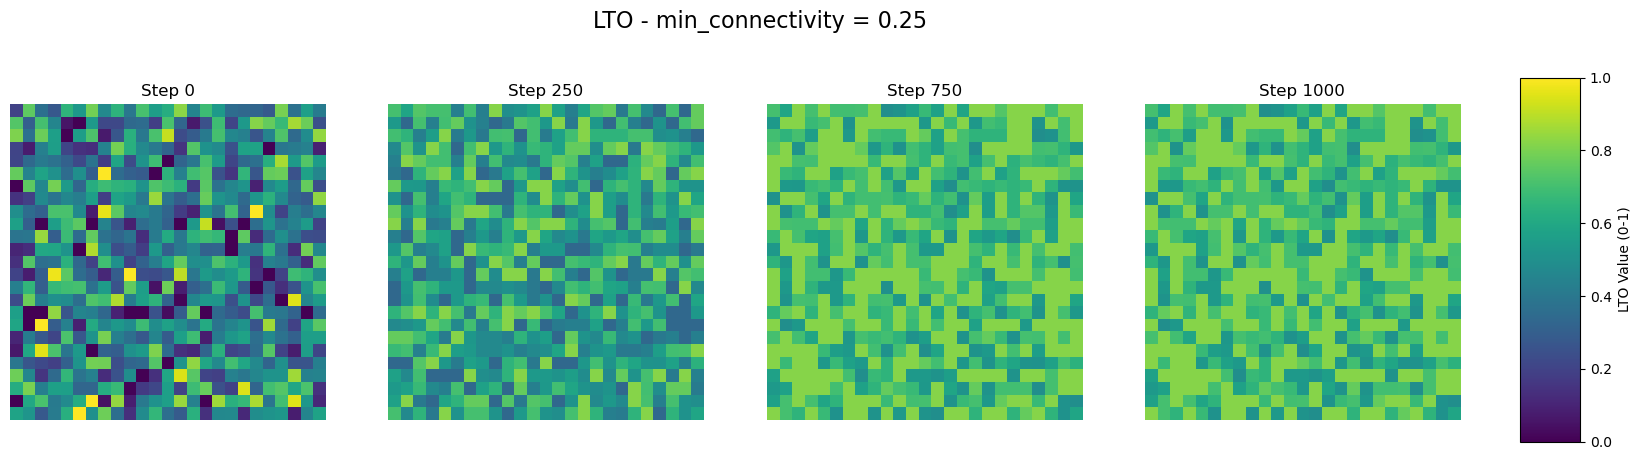

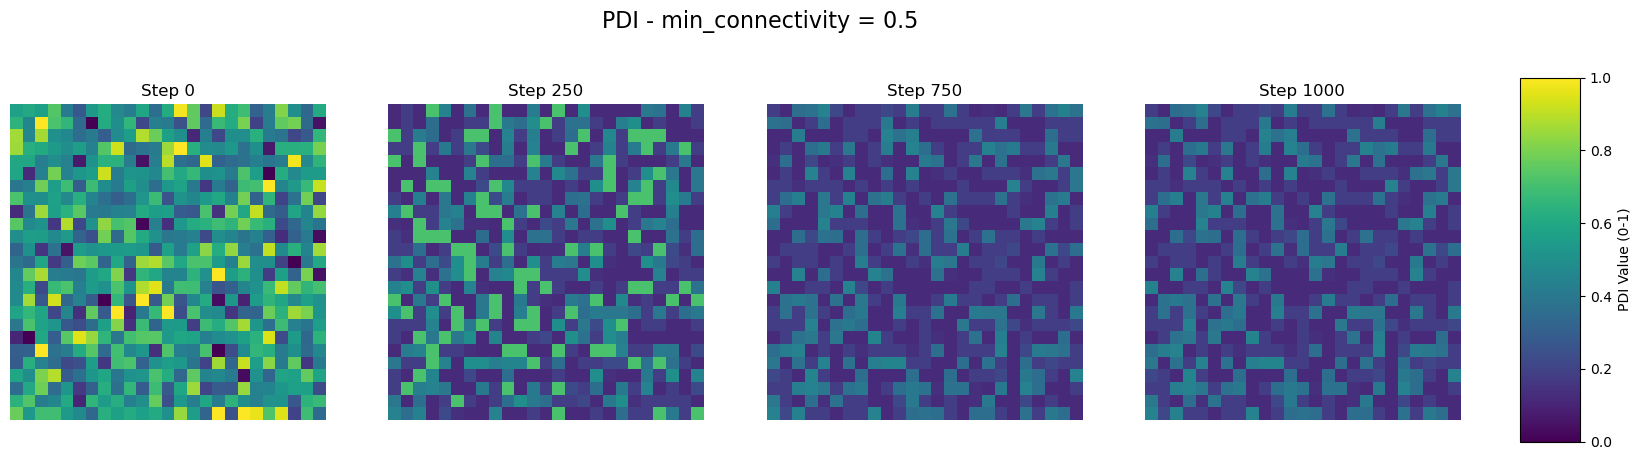

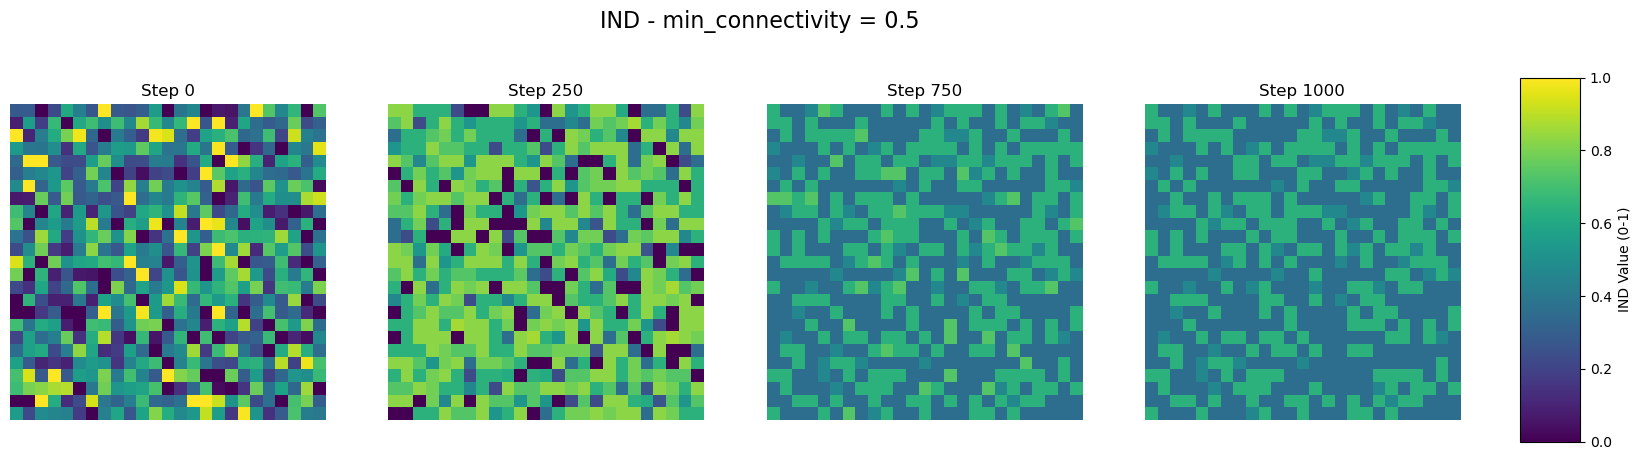

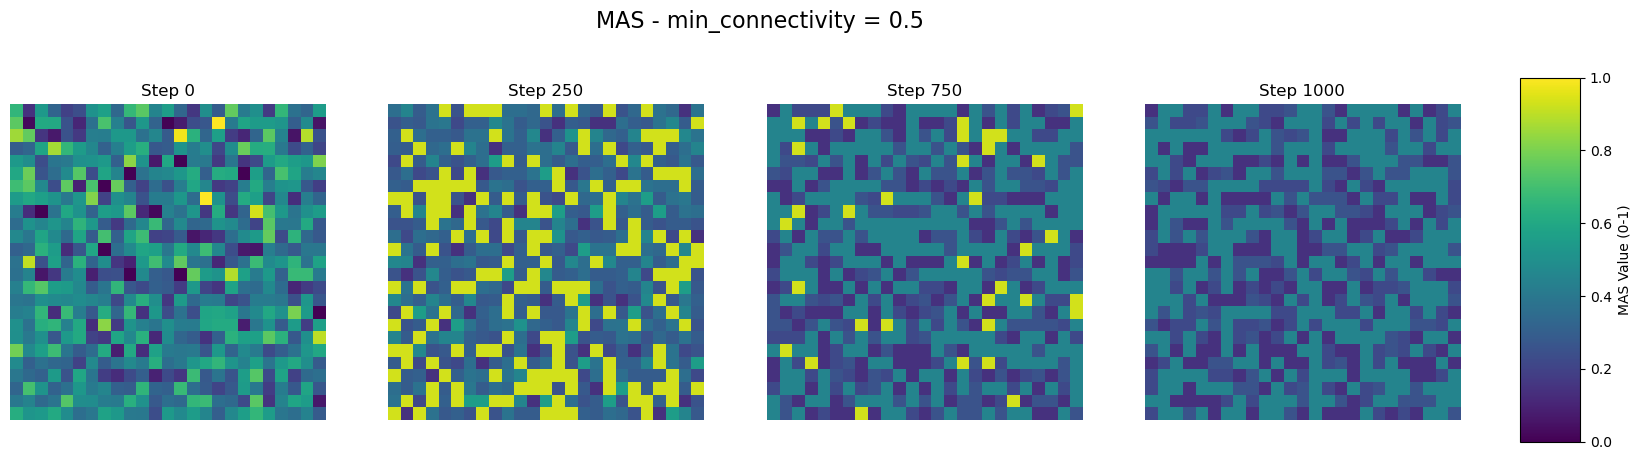

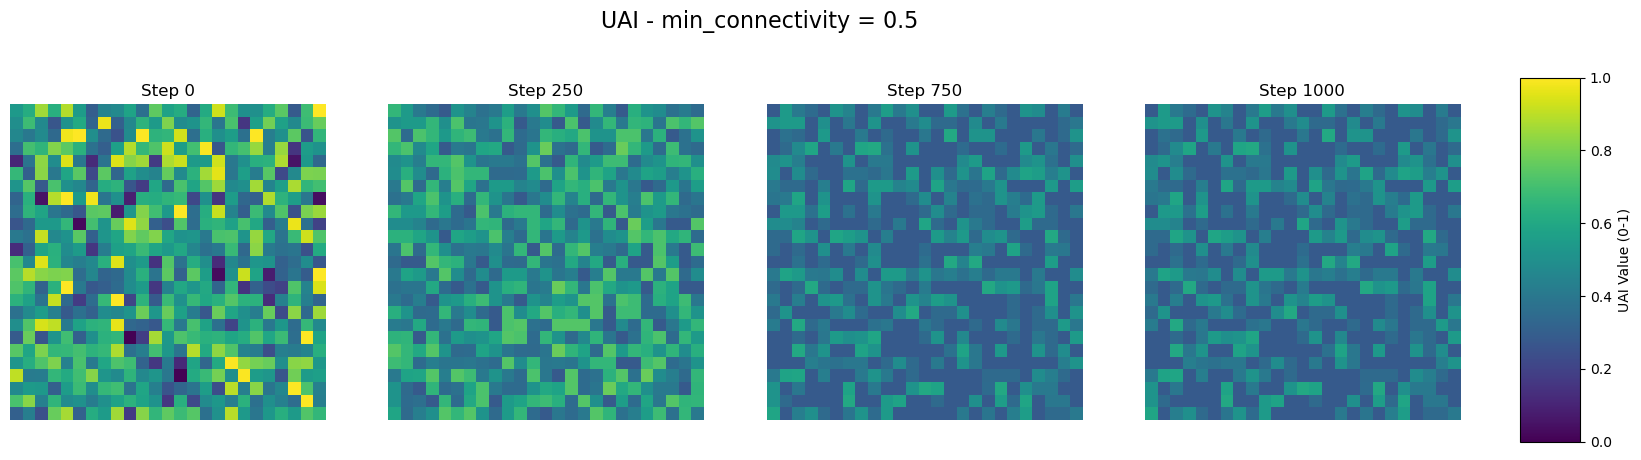

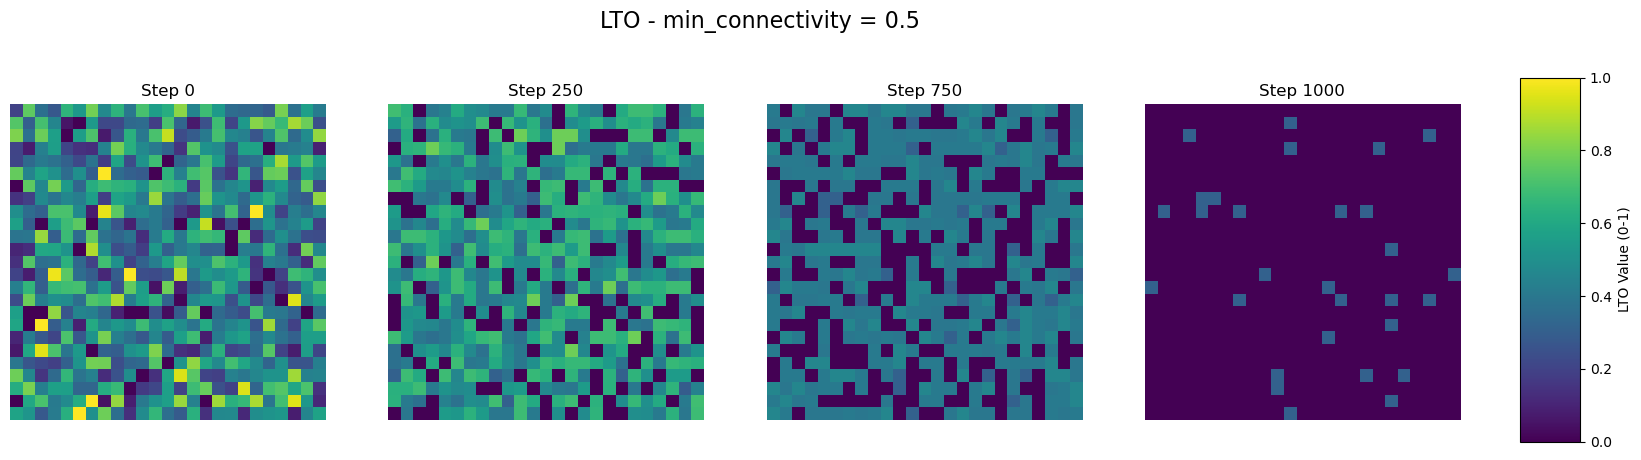

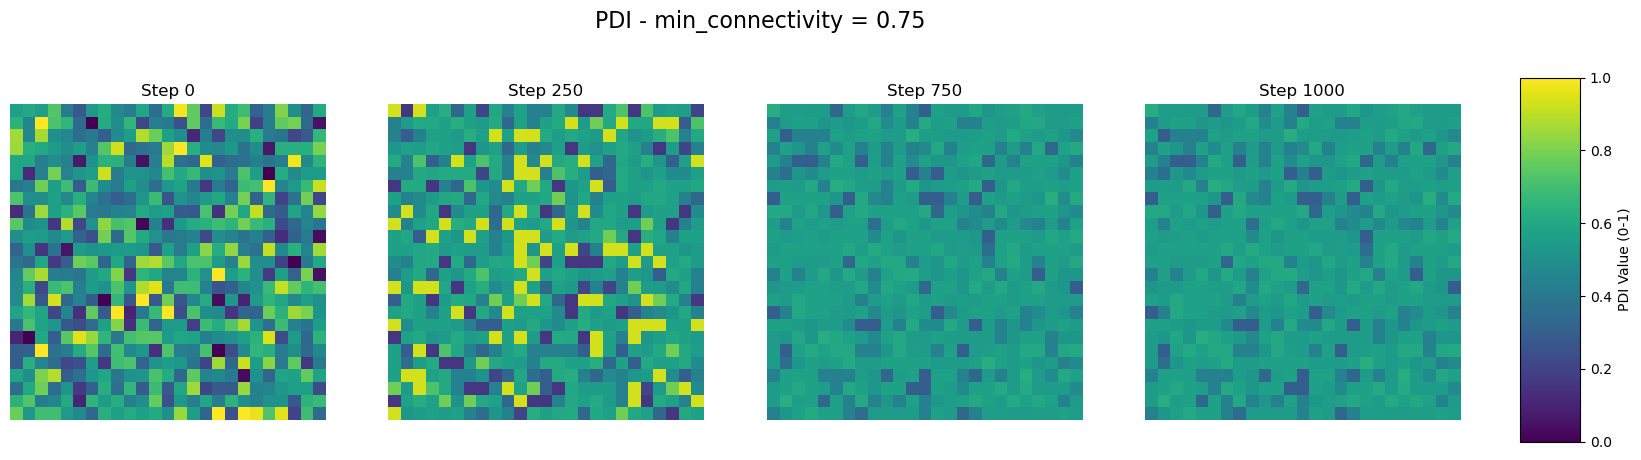

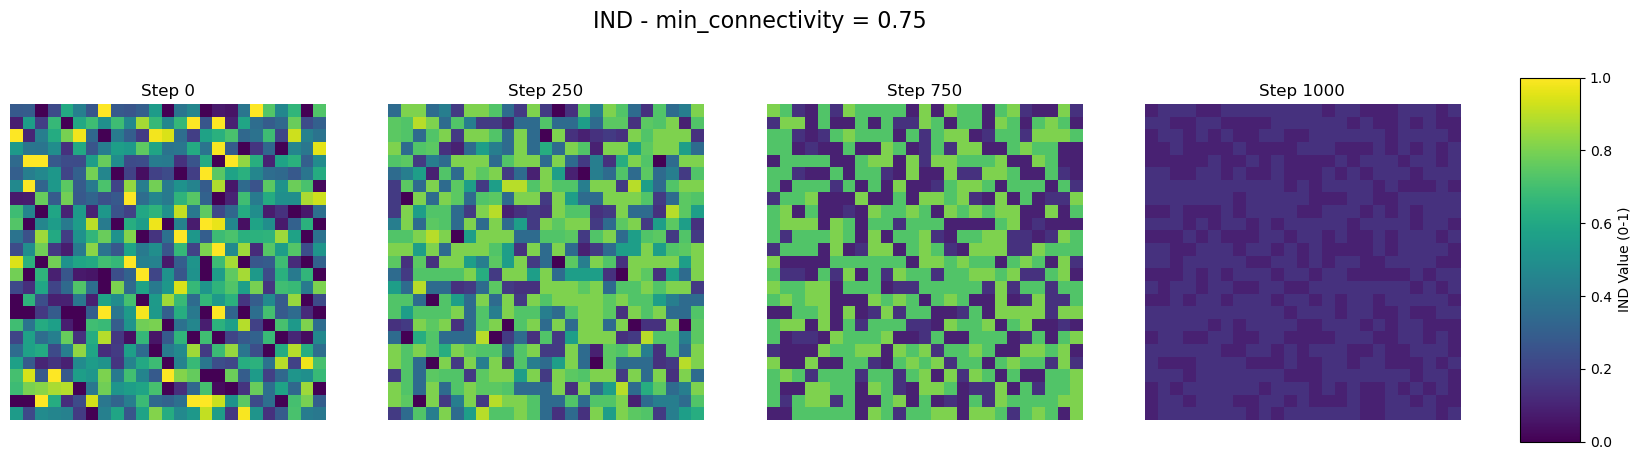

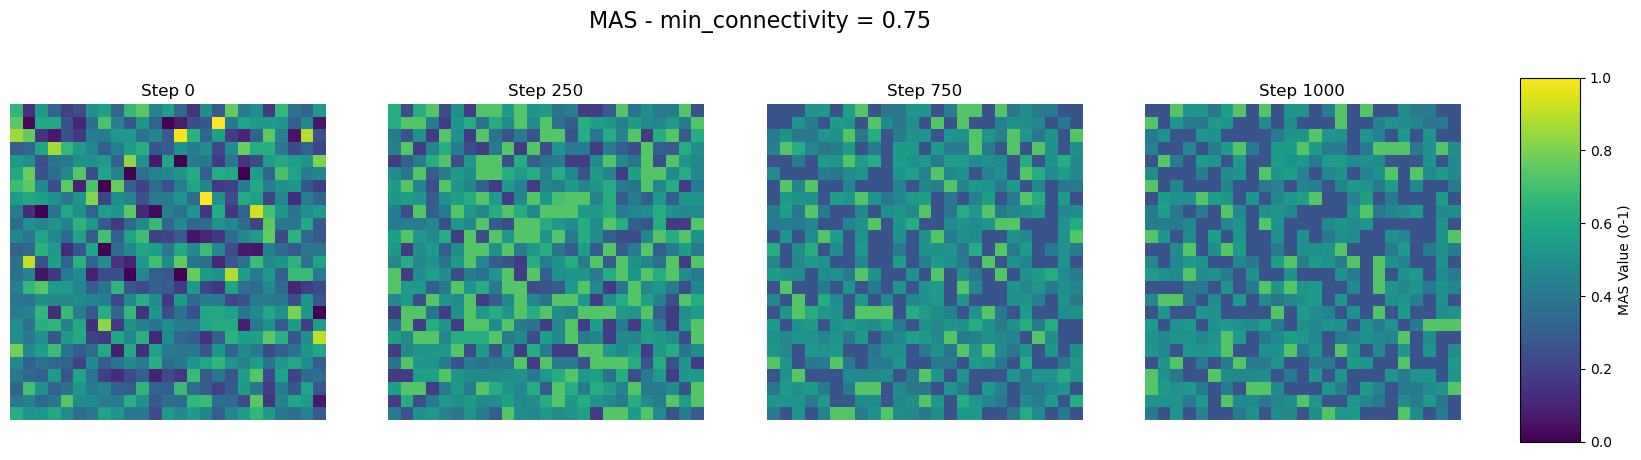

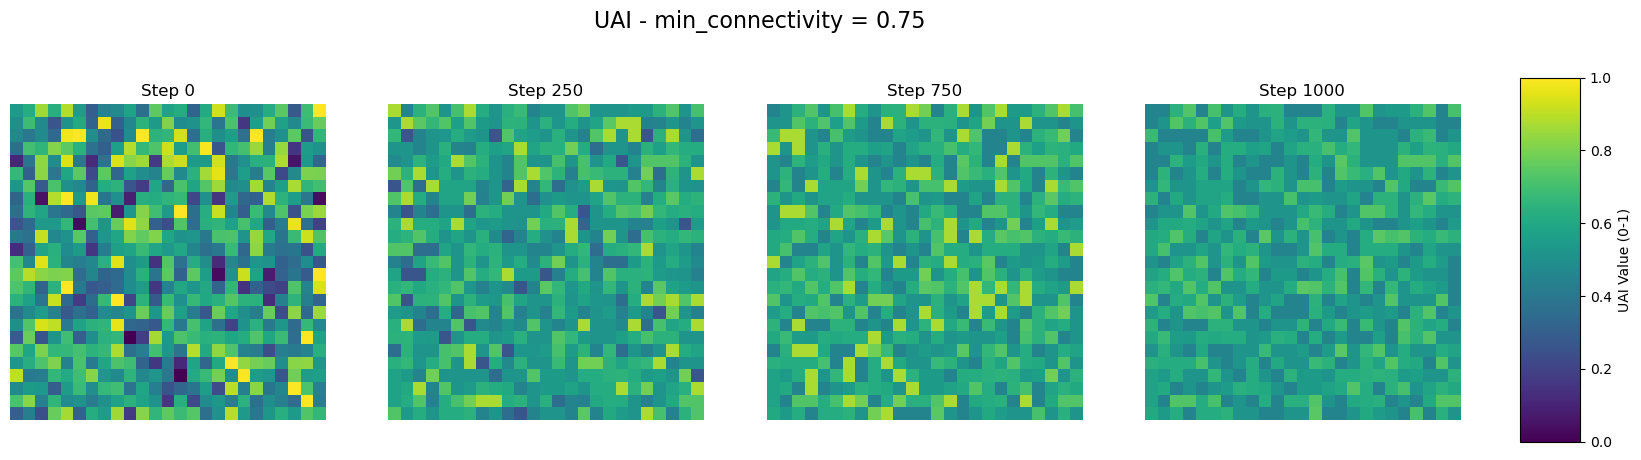

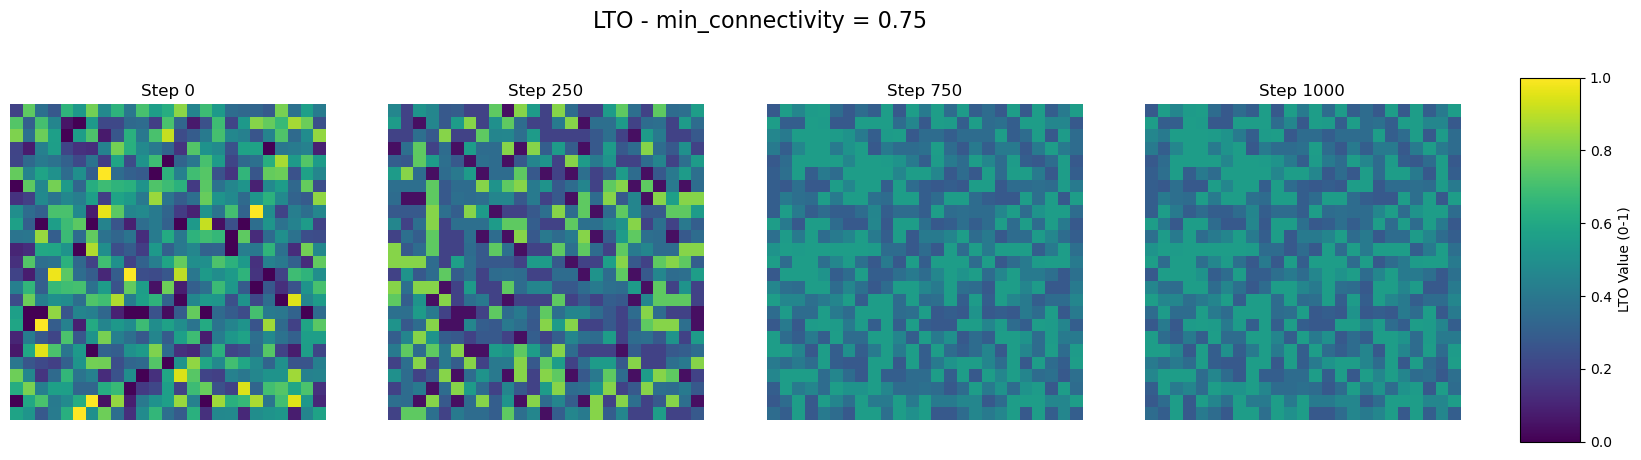

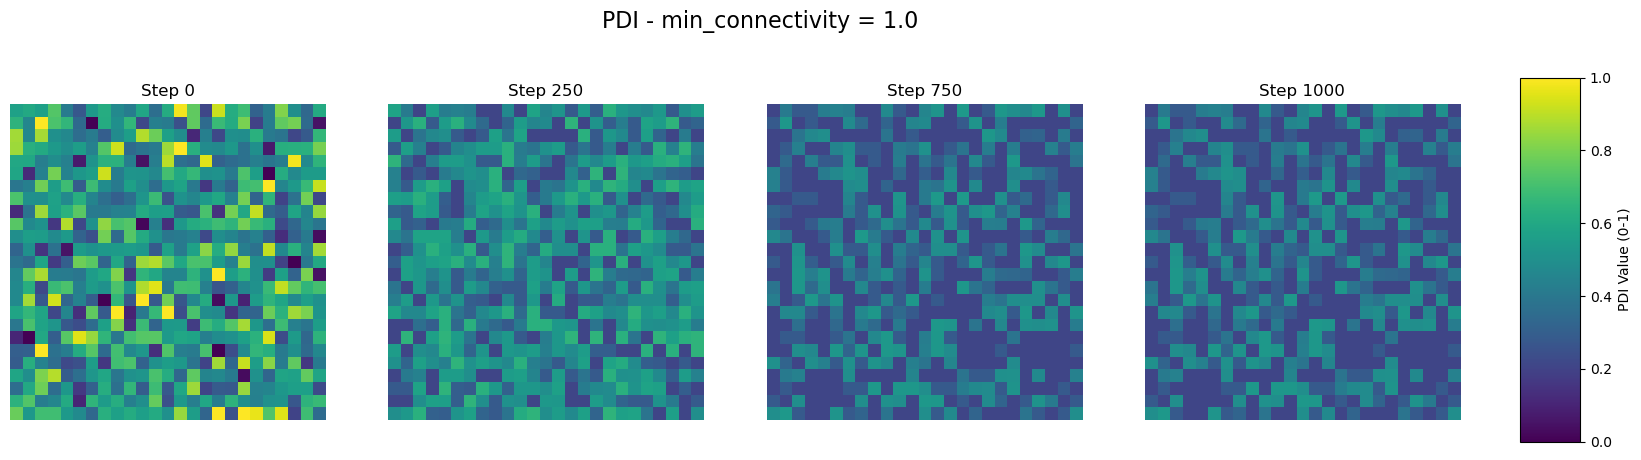

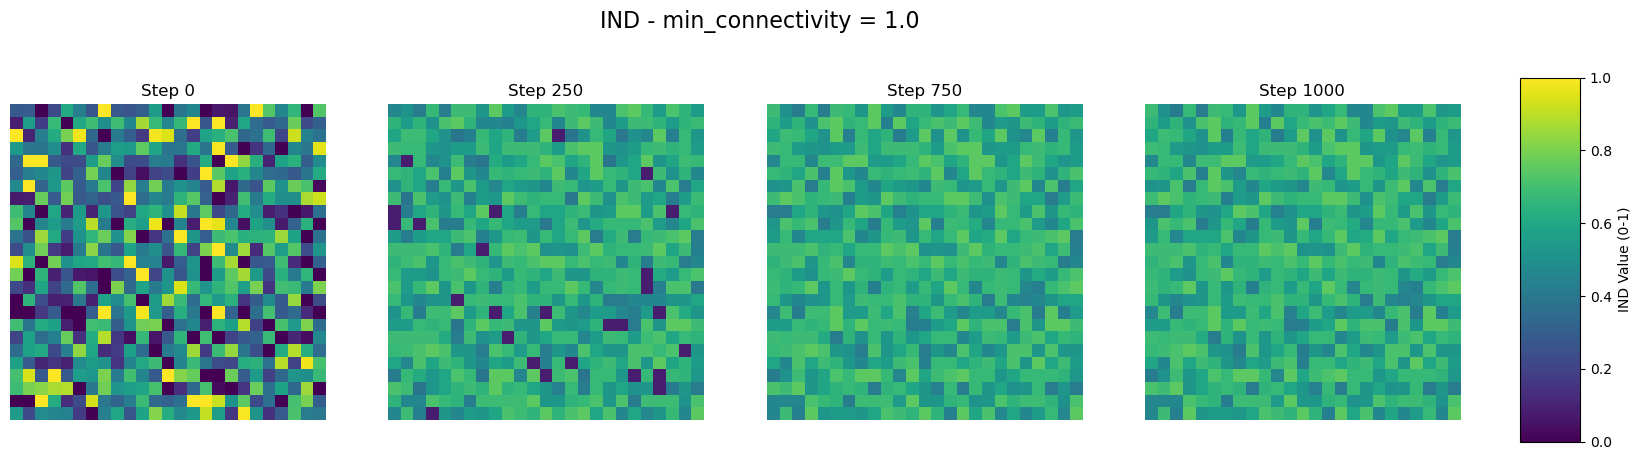

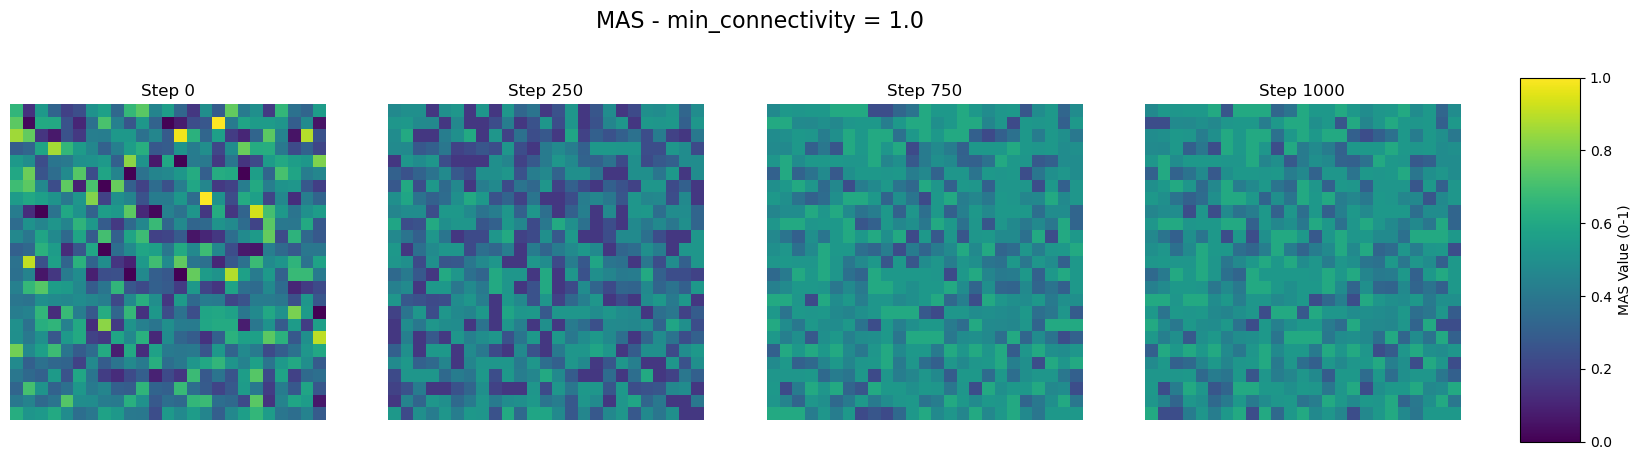

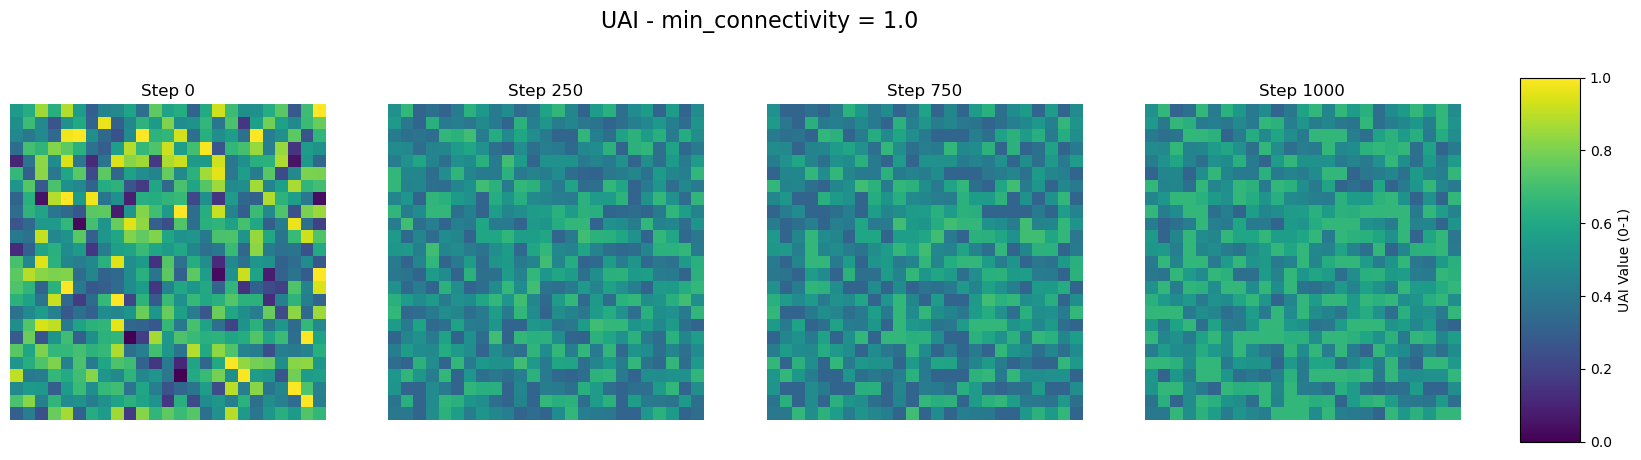

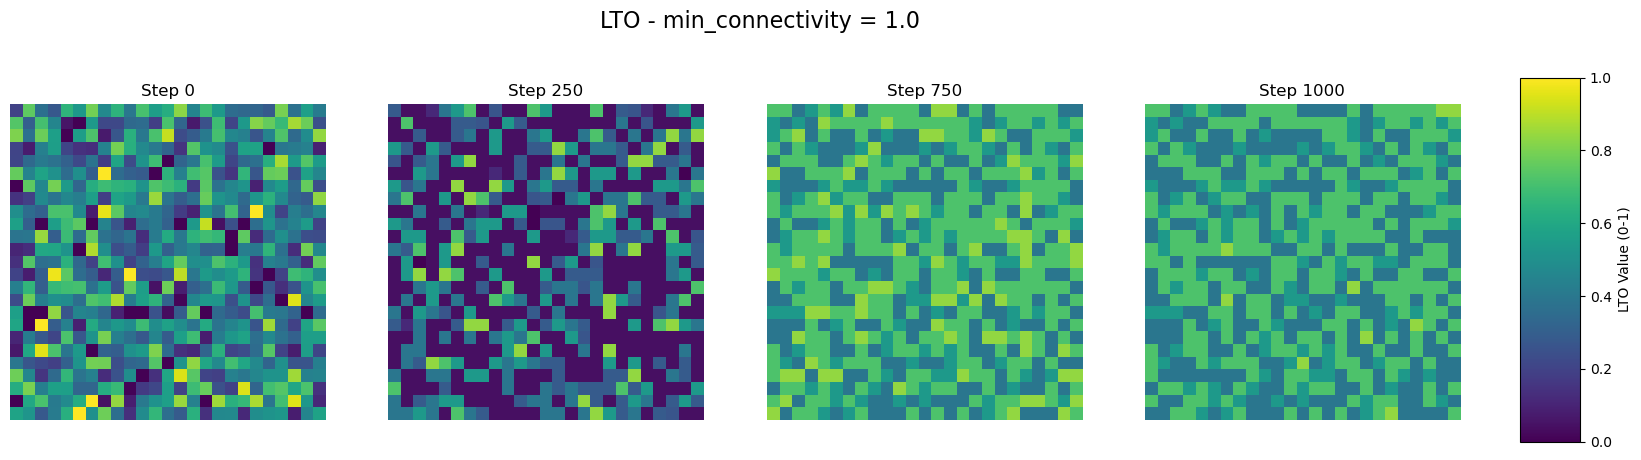

In [2]:
def get_all_dimension_grids_for_current_step(current_model):
    """
    Creates a 3D NumPy array of (width, height, num_dimensions),
    populates it by iterating through agents only ONCE, and returns
    a list of 2D slices. This is significantly faster than the original.
    """
    all_dims_grid = np.full(
        (current_model.grid.width, current_model.grid.height, current_model.num_culture_dimensions),
        np.nan
    )
    
    for agent in current_model.agents:
        x, y = agent.pos
        all_dims_grid[x, y, :] = agent.culture

    grids_for_this_snapshot = [all_dims_grid[:, :, i].T for i in range(current_model.num_culture_dimensions)]
    
    return grids_for_this_snapshot


min_connectivity_values = [0.25, 0.5, 0.75, 1.0]
steps_to_snapshot = [0, 250, 750, 1000]
max_steps = 1000

for min_conn in min_connectivity_values:
    print(f"Running simulation for min_connectivity = {min_conn}")
    
    model = CulturalModel(
        width=25,
        height=25,
        min_connectivity=min_conn,
        difference_threshhold=0.33,
        seed=42
    )

    snapshot_data = {}

    for step_num in range(max_steps + 1):
        if step_num in steps_to_snapshot:
            print(f"  - Snapping grid state at step {step_num}")
            snapshot_data[step_num] = get_all_dimension_grids_for_current_step(model)
        
        if step_num < max_steps:
            model.step()

    dimension_names = [d_stat['name'] for d_stat in model.culture_dimension_stats]
    num_dimensions = model.num_culture_dimensions
    num_snapshot_occasions = len(steps_to_snapshot)

    for dim_idx in range(num_dimensions):
        current_dimension_name = dimension_names[dim_idx]

        fig, axes = plt.subplots(1, num_snapshot_occasions, figsize=(5 * num_snapshot_occasions, 5.2))
        if num_snapshot_occasions == 1:
            axes = [axes] 

        im = None
        for i, step_val in enumerate(steps_to_snapshot):
            grid_to_plot = snapshot_data[step_val][dim_idx]
            ax = axes[i]
            im = ax.imshow(grid_to_plot, cmap="viridis", vmin=0, vmax=1)
            ax.set_title(f"Step {step_val}")
            ax.set_axis_off()

        if im is not None:
            fig.subplots_adjust(right=0.85, top=0.88)
            cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
            fig.colorbar(im, cax=cbar_ax, label=f"{current_dimension_name} Value (0-1)")
        else:
            fig.subplots_adjust(top=0.88)

        fig.suptitle(f"{current_dimension_name} - min_connectivity = {min_conn}", fontsize=16)


In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

min_conn_to_animate = 0.75  # Let's just animate one scenario
dim_to_animate = 1         # Animate the dimension (e.g., PDI)
max_steps = 2000
frame_interval = 10         # Store a frame for the animation every 10 steps

print(f"Running simulation to collect animation frames...")
model = CulturalModel(
    width=25,
    height=25,
    min_connectivity=min_conn_to_animate,
    difference_threshhold=0.33,
    seed=42
)

# A list to hold the grid state for each frame of the animation
animation_frames = []

for step_num in range(max_steps + 1):
    # Store a snapshot at the desired interval
    if step_num % frame_interval == 0:
        # We only need the grid for the specific dimension we want to animate
        grid_snapshot = get_all_dimension_grids_for_current_step(model)[dim_to_animate]
        animation_frames.append(grid_snapshot)
    
    model.step()

print(f"Data collection complete. {len(animation_frames)} frames stored.")

dimension_name = model.culture_dimension_stats[dim_to_animate]['name']

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_axis_off()

im = ax.imshow(animation_frames[0], cmap="viridis", vmin=0, vmax=1)
fig.colorbar(im, ax=ax, label=f"{dimension_name} Value (0-1)")

# The update function that FuncAnimation will call for each frame
def update(frame_num):
    grid_data = animation_frames[frame_num]
    im.set_data(grid_data)
    step = frame_num * frame_interval
    ax.set_title(f"{dimension_name} - Step {step}", fontsize=16)
    return [im]

# Create the animation object
anim = FuncAnimation(
    fig,
    update,
    frames=len(animation_frames), # Number of frames
    interval=50,  # Delay between frames in milliseconds
    blit=True
)

plt.close()
HTML(anim.to_jshtml())

Running simulation to collect animation frames...
Data collection complete. 201 frames stored.


In [4]:
min_connectivity = [0.25, 0.5, 0.75, 1.0]
all_runs_data = []
collection_interval = 10

for mc_value in min_connectivity:
    model = CulturalModel(
        width=25,
        height=25,
        min_connectivity=mc_value,
        difference_threshhold=0.3,
        seed=42
    )
    
    for i in range(2000):
        model.step()
        if (i + 1) % collection_interval == 0:
            model.datacollector.collect(model)
    run_data = model.datacollector.get_model_vars_dataframe()
    run_data["min_connectivity"] = mc_value
    run_data["Step"] = run_data.index * collection_interval
    all_runs_data.append(run_data)

final_combined_data = pd.concat(all_runs_data, ignore_index=True)

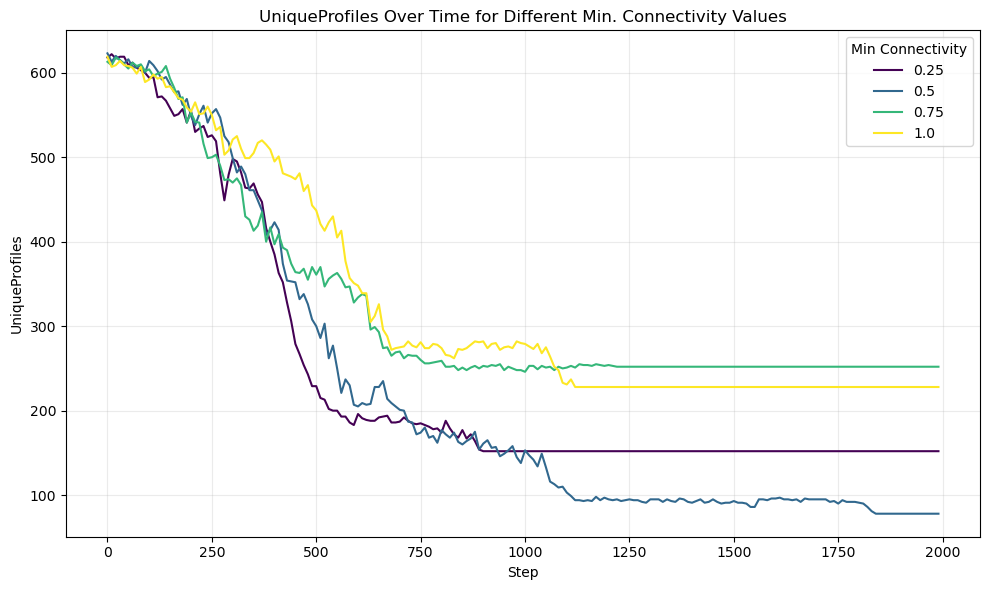

In [5]:
plt.figure(figsize=(10, 6)) 

sns.lineplot(data=final_combined_data, x="Step", y="UniqueProfiles", hue="min_connectivity", palette="viridis", legend="full")
plt.xlabel("Step") 
plt.ylabel("UniqueProfiles")
plt.title("UniqueProfiles Over Time for Different Min. Connectivity Values")
plt.grid(alpha=.25)
plt.legend(title="Min Connectivity") 
plt.tight_layout()

In [68]:
def find_equilibrium(df: pd.DataFrame, column: str, min_connectivity_value: float):
    """
    Finds the first index (or time) from which the values in `column` stop changing.
    """
    series = final_combined_data[final_combined_data["min_connectivity"] == min_connectivity_value][column]
    stability_window = 5
    last_value = series.iloc[-1]
    for i in range(len(series) - stability_window + 1):
        window = series.iloc[i:i + stability_window]
        if window.nunique() == 1 and series.iloc[i] == last_value:
            return i * collection_interval

    return series.index[0] 

In [69]:
min_connectivity_values = [0.25, 0.5, 0.75, 1.0]

for min_connectivity in min_connectivity_values:
    equilibrium = find_equilibrium(final_combined_data, "UniqueProfiles", min_connectivity)
    print(f"For min_connectivity = {min_connectivity} the equilibrium is {equilibrium} Steps")

For min_connectivity = 0.25 the equilibrium is 900 Steps
For min_connectivity = 0.5 the equilibrium is 1840 Steps
For min_connectivity = 0.75 the equilibrium is 1220 Steps
For min_connectivity = 1.0 the equilibrium is 1120 Steps


In [89]:
def get_final_unique_profiles(df: pd.DataFrame, column:str, step: int, connectivity_values: list):
    """
    Returns the columns count at a given step for specified min_connectivity values.
    """
    results = {}
    for value in connectivity_values:
        filtered = df[(df["Step"] == step) & (df["min_connectivity"] == value)]
        if not filtered.empty:
            results[value] = filtered[column].iloc[0]
        else:
            results[value] = None  
    return results

In [90]:
results = get_final_unique_profiles(final_combined_data, "UniqueProfiles", step=final_combined_data["Step"].max(), connectivity_values=[0.25, 0.5, 0.75, 1.0])

for conn, count in results.items():
    print(f"Final unique profiles count for min_connectivity = {conn}: {count}")

Final unique profiles count for min_connectivity = 0.25: 152
Final unique profiles count for min_connectivity = 0.5: 78
Final unique profiles count for min_connectivity = 0.75: 252
Final unique profiles count for min_connectivity = 1.0: 228


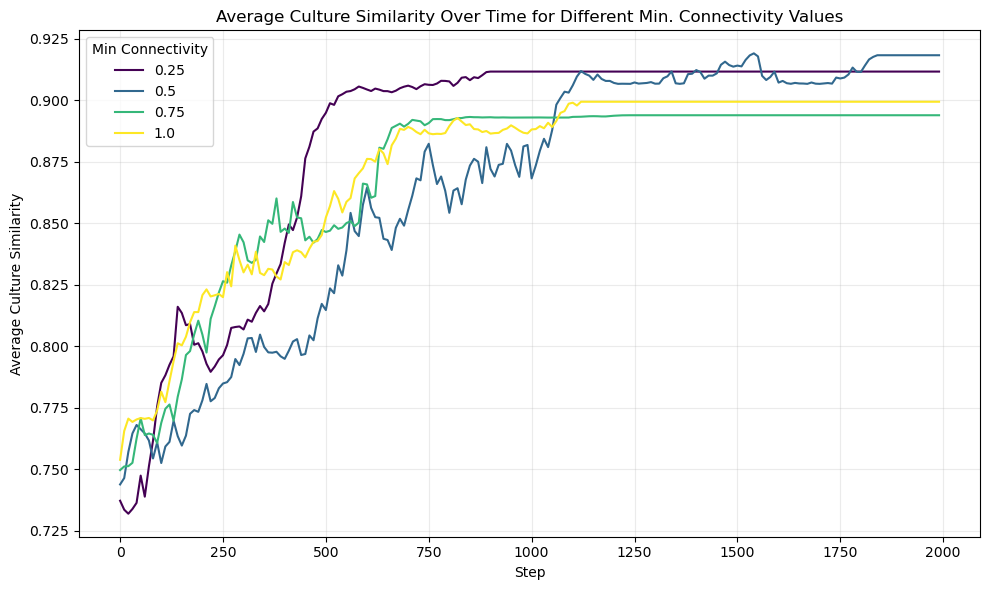

In [7]:
plt.figure(figsize=(10, 6)) 

sns.lineplot(data=final_combined_data, x="Step", y="AverageCultureSimilarity", hue="min_connectivity", palette="viridis", legend="full")
plt.xlabel("Step")
plt.ylabel("Average Culture Similarity")
plt.title("Average Culture Similarity Over Time for Different Min. Connectivity Values")
plt.grid(alpha=.25)
plt.legend(title="Min Connectivity") 
plt.tight_layout()

In [88]:
min_connectivity_values = [0.25, 0.5, 0.75, 1.0]

for min_connectivity in min_connectivity_values:
    equilibrium = find_equilibrium(final_combined_data, "AverageCultureSimilarity", min_connectivity)
    print(f"For min_connectivity = {min_connectivity} the equilibrium is {equilibrium} Steps")

For min_connectivity = 0.25 the equilibrium is 900 Steps
For min_connectivity = 0.5 the equilibrium is 1840 Steps
For min_connectivity = 0.75 the equilibrium is 1230 Steps
For min_connectivity = 1.0 the equilibrium is 1120 Steps


In [93]:
results = get_final_unique_profiles(
    final_combined_data,
    "AverageCultureSimilarity", 
    step=final_combined_data["Step"].max(),
    connectivity_values=[0.25, 0.5, 0.75, 1.0]
    )

for conn, count in results.items():
    print(f"Final unique profiles count for min_connectivity = {conn}: {count:.2f}")

Final unique profiles count for min_connectivity = 0.25: 0.91
Final unique profiles count for min_connectivity = 0.5: 0.92
Final unique profiles count for min_connectivity = 0.75: 0.89
Final unique profiles count for min_connectivity = 1.0: 0.90
